In [1]:
import jax 
import jax.numpy as jnp
import equinox as eqx
import optax
import matplotlib.pyplot as plt

In [2]:
class Model(eqx.Module):
    linear1: eqx.nn.Linear
    linear2: eqx.nn.Linear
    linear3: eqx.nn.Linear

    def __init__(self, key):
        key1, key2, key3 = jax.random.split(key, 3)
        self.linear1 = eqx.nn.Linear(2, 128, key=key1)
        self.linear2 = eqx.nn.Linear(128, 128, key=key2) 
        self.linear3 = eqx.nn.Linear(128, 2, key=key3)

    def __call__(self, x):
        # base = jnp.diag(jnp.array([1, jnp.sin(x[0])**2]))
        base = jnp.diag(jnp.array([1, 1]))
        x = self.linear1(x)
        x = jax.nn.sigmoid(x)
        x = self.linear2(x)
        x = jax.nn.sigmoid(x)
        x = self.linear3(x)
        return jnp.diag(x) + base

In [3]:
key, subkey = jax.random.split(jax.random.PRNGKey(0))
model = Model(key=subkey)

In [4]:
metric = lambda coords, model: model(coords)

In [5]:
pd_metric = jax.jacfwd(metric)

def christoffel(coords, model):
    met = metric(coords, model)
    inv_met = jnp.linalg.inv(met)
    partial_derivs = jnp.einsum('mns -> smn', pd_metric(coords, model))
    sum_partial_derivs = partial_derivs + jnp.einsum('nrm -> mnr', partial_derivs) - jnp.einsum('rmn -> mnr', partial_derivs)
    christ = 0.5 * jnp.einsum('sr, mnr -> smn', inv_met, sum_partial_derivs)
    return christ
pd_christoffel = jax.jacfwd(christoffel)

@jax.jit
def riemann_curvature(coords, model):
    christ = christoffel(coords, model)
    pd_christ = jnp.einsum('rmns -> srmn', pd_christoffel(coords, model))
    return jnp.einsum('mrns -> rsmn', pd_christ) - jnp.einsum('nrms -> rsmn', pd_christ) + jnp.einsum('rml, lns -> rsmn', christ, christ) - jnp.einsum('rnl, lms -> rsmn', christ, christ)

@jax.jit
def ricci_tensor(coords, model):
    riemann = riemann_curvature(coords, model)
    return jnp.einsum('rsru -> su', riemann)

@jax.jit
def ricci_scalar(coords, model):
    return jnp.einsum('mn, mn -> ', jnp.linalg.inv(metric(coords, model)), ricci_tensor(coords, model))

In [6]:
ricci_scalar(jnp.array([1., 0]), model)

DeviceArray(0.00034027, dtype=float32)

In [7]:
optim = optax.adam(1e-3)
# optim = optax.sgd(1e-6)
opt_state = optim.init(model)

In [8]:
@eqx.filter_value_and_grad
def compute_loss(model, coords):
    ricci_s = jax.vmap(ricci_scalar, in_axes=[0, None])(coords, model)
    # ricci_t = jax.vmap(ricci_tensor, in_axes=[0, None])(coords, model)
    # einstein_tensor = ricci_t - 0.5 * ricci_s.reshape(-1, 1, 1) * jax.vmap(metric, in_axes=[0, None])(coords, model)
    # return jnp.mean(einstein_tensor**2)
    return jnp.mean((ricci_s)**2)

# Important for efficiency whenever you use JAX: wrap everything into a single JIT
# region.
@eqx.filter_jit
def make_step(model, coords, opt_state):
    loss, grads = compute_loss(model, coords)
    updates, opt_state = optim.update(grads, opt_state)
    model = eqx.apply_updates(model, updates)
    return loss, model, opt_state

In [9]:
loss_list = []
for step in range(100):
    key, subkey = jax.random.split(key)
    data = jax.random.normal(subkey, (128, 2))
    loss, model, opt_state = make_step(model, data, opt_state)
    loss = loss.item()
    loss_list.append(loss)
    print(f"step={step}, loss={loss}")

step=0, loss=6.097907316870987e-07
step=1, loss=1.1115288600649365e-07
step=2, loss=3.670107844300219e-07
step=3, loss=3.501069727462891e-07
step=4, loss=9.594231897835925e-08
step=5, loss=2.5743210230189106e-08
step=6, loss=6.371824667894543e-08
step=7, loss=1.236021631711992e-07
step=8, loss=1.1950123735005036e-07
step=9, loss=7.827041770269716e-08
step=10, loss=5.652592349747465e-08
step=11, loss=2.426977729896862e-08
step=12, loss=5.729705598866985e-09
step=13, loss=6.60269083851972e-09
step=14, loss=2.1523737459006043e-08
step=15, loss=3.369224899074652e-08
step=16, loss=3.7265564856170386e-08
step=17, loss=3.413951077391175e-08
step=18, loss=2.084589922901614e-08
step=19, loss=1.3092192219232857e-08
step=20, loss=5.855413487410033e-09
step=21, loss=3.1240310338631616e-09
step=22, loss=4.9500386012368836e-09
step=23, loss=9.38619315604683e-09
step=24, loss=1.0647275949793311e-08
step=25, loss=1.3077218419255132e-08
step=26, loss=1.1395273169512166e-08
step=27, loss=9.1976426475071

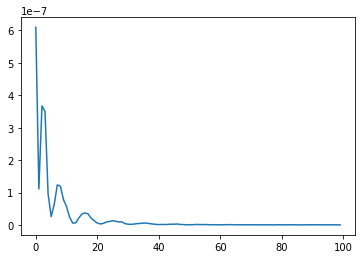

In [10]:
plt.plot((jnp.array(loss_list)))

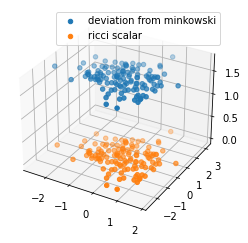

In [12]:
# 3d plot of metric
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data[:, 0], data[:, 1], jnp.sum((jax.vmap(metric, in_axes=[0, None])(data, model) - jnp.diag(jnp.array([1., 1])))**2, axis=[1, 2]).reshape(-1, 1), label='deviation from minkowski')
ax.scatter(data[:, 0], data[:, 1], jax.vmap(ricci_scalar, in_axes=[0, None])(data, model), label='ricci scalar')
plt.legend()
plt.show()

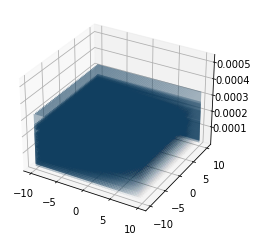

In [13]:
# 3d plot of ricci scaler
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
grid = jnp.meshgrid(jnp.linspace(-10, 10, 100), jnp.linspace(-10, 10, 100))
grid_data = jnp.stack([grid[0].reshape(-1), grid[1].reshape(-1)], axis=1)
ax.plot_surface(grid_data[:, 0], grid_data[:, 1], jnp.abs(jax.vmap(ricci_scalar, in_axes=[0, None])(grid_data, model).reshape(-1, 1)), alpha=0.2)
plt.show()

In [15]:
(jax.vmap(metric, in_axes=[0, None])(data, model))[:5]

DeviceArray([[[1.8424449, 0.       ],
              [0.       , 1.9953415]],

             [[1.8464202, 0.       ],
              [0.       , 1.999564 ]],

             [[1.84812  , 0.       ],
              [0.       , 1.9946854]],

             [[1.850438 , 0.       ],
              [0.       , 1.9991605]],

             [[1.8431892, 0.       ],
              [0.       , 1.9963337]]], dtype=float32)